<a href="https://colab.research.google.com/github/VasanthPrakasam/DL-P5---Building_a_Brain_Tumor_Detector_using_MRI_Images/blob/main/VGG16_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finding the MRI brain tumor detection dataset**
https://www.kaggle.com/datasets/ivasanthp/brain-tumor-mri-image-classification/data?select=Tumour-20250908T112353Z-1-001

# **Import packages**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.utils import shuffle
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import datetime
import shutil
import torch
import glob

import cv2
import os
import io

from keras import models, layers

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("PyTorch version:", torch.__version__)
print("All imports successful!")

TensorFlow version: 2.19.0
Keras version: 3.10.0
PyTorch version: 2.8.0+cu126
All imports successful!


# **Data Preperation**



    Load all training and testing data

    Pre-processing images (apply opencv functions : bilateralFilter,applyColorMap,resize)

    Append images and labels into Python list

    Convert lists into numpy array and normalize images with devide by 255

    One Hot Encoding on the labels

    Dividing the dataset into Training and Validation sets


In [ ]:
import os
import zipfile
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/Vasanth_P')

# 2. Specify paths
drive_path = '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification'  # Adjust if your file is in a different folder
zip_file_path = os.path.join(drive_path, 'Tumour-20250908T112353Z-1-001.zip')  # Change to your zip file name
extract_path = '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset'  # Where to extract files

# 3. Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# 4. Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Extracted files to: {extract_path}")

Mounted at /content/Vasanth_P
Extracted files to: /content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset


In [ ]:
# 5. Verify the extracted folders
dataset_path = os.path.join(extract_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset')  # Change to your extracted folder name
train_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/train')
val_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/valid')
test_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/test')

print("\nVerifying directories:")
print("Train exists:", os.path.exists(train_dir))
print("Validation exists:", os.path.exists(val_dir))
print("Test exists:", os.path.exists(test_dir))

# 6. Sample directory listing (optional)
if os.path.exists(train_dir):
    print("\nSample train directory contents:")
    print(os.listdir(train_dir)[:5])  # Show first 5 items


Verifying directories:
Train exists: True
Validation exists: True
Test exists: True

Sample train directory contents:
['_classes.csv', 'no_tumor', 'pituitary', 'meningioma', 'glioma']


In [ ]:
## Data Preprocessing and Augmentation

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]

    # Data augmentation parameters
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift by ±20% of width
    height_shift_range=0.2,  # Random vertical shift by ±20% of height
    zoom_range=0.2,  # Random zoom between 80% and 120%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping (can enable if appropriate)
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Validation and test generators (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Set image size and batch size
img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [ ]:
# Get class names and number of classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of classes: 4


# **Build a simple CNN model**

In [ ]:
# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 692ms/step - accuracy: 0.4097 - loss: 1.4458 - precision: 0.4646 - recall: 0.1057 - val_accuracy: 0.6583 - val_loss: 0.9680 - val_precision: 0.7798 - val_recall: 0.2729
Epoch 2/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5938 - loss: 0.9589 - precision: 0.8889 - recall: 0.2500

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5938 - loss: 0.9589 - precision: 0.8889 - recall: 0.2500 - val_accuracy: 0.6750 - val_loss: 0.9840 - val_precision: 0.7435 - val_recall: 0.2958
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 589ms/step - accuracy: 0.5692 - loss: 1.0326 - precision: 0.7181 - recall: 0.3009 - val_accuracy: 0.5604 - val_loss: 1.0821 - val_precision: 0.6604 - val_recall: 0.4417
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6129 - loss: 0.8850 - precision: 0.7500 - recall: 0.4839 - val_accuracy: 0.5167 - val_loss: 1.2446 - val_precision: 0.5655 - val_recall: 0.3958
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 583ms/step - accuracy: 0.6725 - loss: 0.8348 - precision: 0.7505 - recall: 0.5452 - val_accuracy: 0.4750 - val_loss: 1.1970 - val_precision: 0.5579 - val_recall: 0.3917
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.6250 - loss: 0.7846 - precision: 0.7826 - recall: 0.5625 - val_accuracy: 0.5604 - val_loss: 1.0493 - val_p

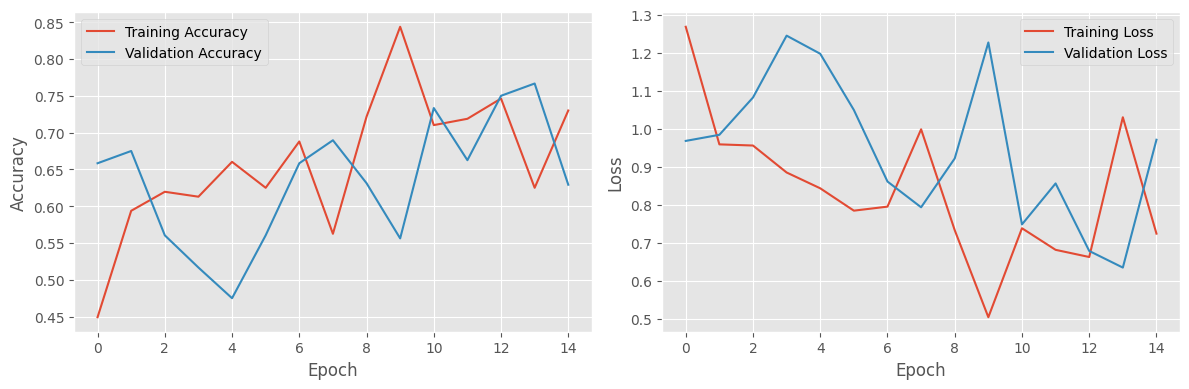

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.5513 - loss: 1.2409 - precision: 0.6835 - recall: 0.5001

Test accuracy: 0.6260
Test precision: 0.7157
Test recall: 0.5732


In [ ]:
# Get true classes
true_classes = test_generator.classes

In [ ]:
# Get predictions on the test set
predictions = model.predict(test_generator)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.89      0.49      0.63        80
  meningioma       0.68      0.51      0.58        63
    no_tumor       0.43      0.94      0.59        49
   pituitary       0.77      0.69      0.73        54

    accuracy                           0.63       246
   macro avg       0.69      0.65      0.63       246
weighted avg       0.72      0.63      0.63       246


Confusion Matrix:
[[39 11 22  8]
 [ 4 32 24  3]
 [ 1  2 46  0]
 [ 0  2 15 37]]


# **VGG16 Evaluation**

In [ ]:
#Setup and Data Preparation
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                          InceptionV3, EfficientNetB0)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dataset_path = os.path.join(extract_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset')  # Change to your extracted folder name

train_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/train')
val_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/valid')
test_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/test')

# Data generators setup
img_size = (224, 224)
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

# Results storage
model_comparison = []

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


In [ ]:
def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history


In [ ]:
vgg_model, vgg_history = evaluate_vgg16()
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2579 - loss: 1.5565 - precision: 0.2390 - recall: 0.0605 - val_accuracy: 0.5578 - val_loss: 1.2336 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - accuracy: 0.4689 - loss: 1.2394 - precision: 0.7832 - recall: 0.0617 - val_accuracy: 0.5996 - val_loss: 1.1162 - val_precision: 0.8977 - val_recall: 0.1574
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 617ms/step - accuracy: 0.6024 - loss: 1.0915 - precision: 0.8259 - recall: 0.1781 - val_accuracy: 0.6594 - val_loss: 1.0179 - val_precision: 0.8870 - val_recall: 0.2032
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 681ms/step - accuracy: 0.6522 - loss: 1.0086 - precision: 0.8352 - recall: 0.2318 - val_accuracy: 0.6733 - val_loss: 0.9555 - val_precision: 0.7946 - val_recall: 0.2928
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 613ms/step - accuracy: 0.6523 - loss: 0.9709 - precision: 0.7814 - recall: 0.2879 - val_accuracy: 0.6693 - va

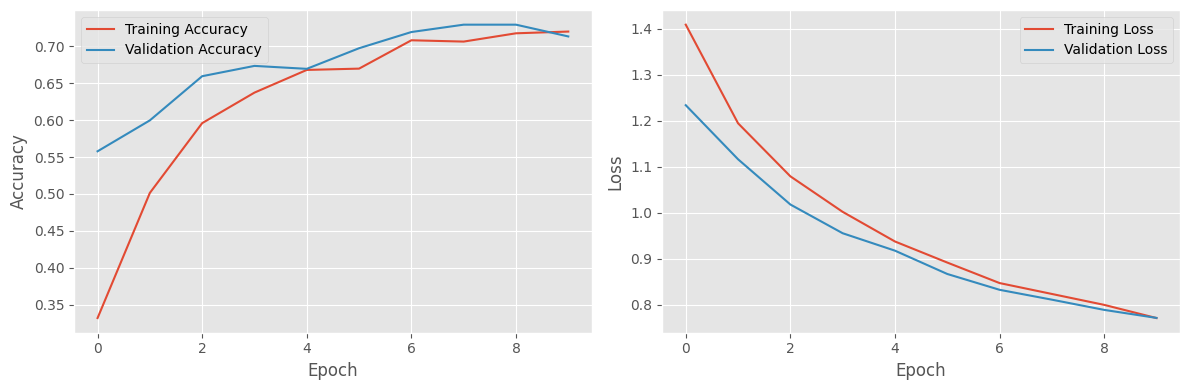

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.7070 - loss: 0.7416 - precision: 0.8514 - recall: 0.5417

Test accuracy: 0.7073
Test precision: 0.8456
Test recall: 0.5122
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step


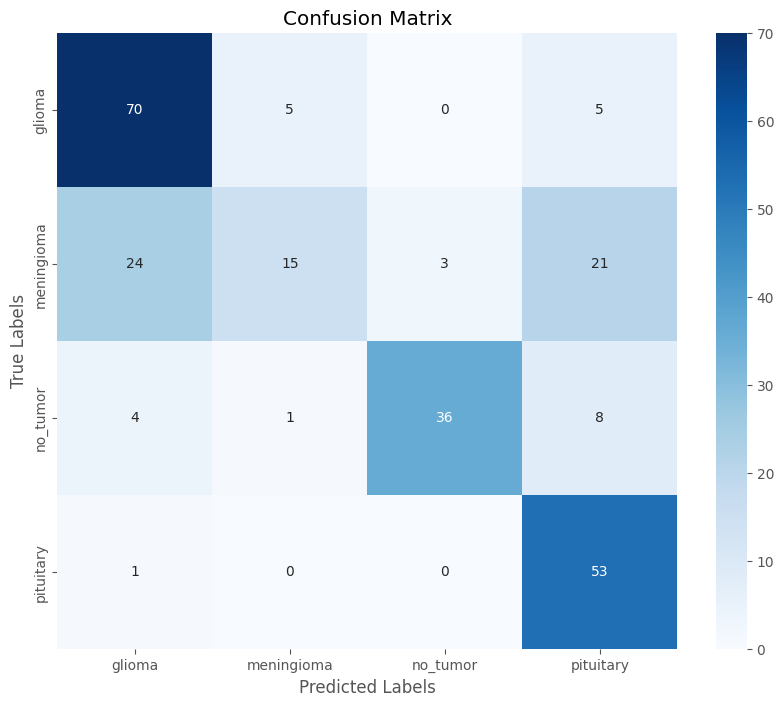

In [ ]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()